# Welcome to chessGPT

In [1]:
import chess
import chess.pgn as pgn
import itertools
import numpy as np

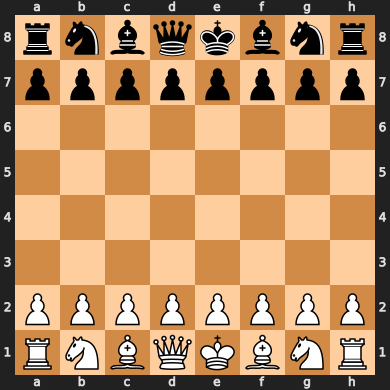

In [2]:
board = chess.Board()
board

## Board encoding

We encode the board in such a way that we garantee the output vector will have a constant length 

In [3]:
def get_pieces(board):
    """We will keep the same encoding as in the FEN notation.
    But we will encode empty squares with a # character.
    """
    fen = board.fen()
    pieces = fen.split()[0]
    for piece in pieces:
        if piece.isdecimal():
            pieces = pieces.replace(piece, '#' * int(piece))
    return pieces


def get_turn(board):
    """We will choose an encoding that has no intersection with the pieces encoding.
    0: black
    1: white
    """
    return "0" if board.turn == chess.BLACK else "1"


def get_castling_rights(board):
    """We will choose an encoding that has no intersection with the pieces encoding.
    u: no castling rights for black
    U: no castling rights for white
    v: queenside castling rights for black
    V: queenside castling rights for white
    w: kingside castling rights for black
    W: kingside castling rights for white
    x: both castling rights for black
    X: both castling rights for white
    """

    castling_rights = ["u", "U"]

    if board.has_queenside_castling_rights(chess.BLACK) and board.has_kingside_castling_rights(chess.BLACK):
        castling_rights[0] = "x"
    elif board.has_queenside_castling_rights(chess.BLACK):
        castling_rights[0] = "v"
    elif board.has_kingside_castling_rights(chess.BLACK):
        castling_rights[0] = "w"
    
    if board.has_queenside_castling_rights(chess.WHITE) and board.has_kingside_castling_rights(chess.WHITE):
        castling_rights[1] = "X"
    elif board.has_queenside_castling_rights(chess.WHITE):
        castling_rights[1] = "V"
    elif board.has_kingside_castling_rights(chess.WHITE):
        castling_rights[1] = "W"

    return "".join(castling_rights)


def transform(board):
    pieces = get_pieces(board)
    turn = get_turn(board)
    castling = get_castling_rights(board)
    return pieces + " " + turn + " " + castling

In [4]:
board_vocab = [ ' ', '/', '0', '1', 'u', 'U', 'v', 'V', 'w', 'W', 'x', 'X', '#', 'K', 'Q', 'R', 'B', 'N', 'P', 'k', 'q', 'r', 'b', 'n', 'p']
fen = transform(board)
print(board)
print(fen)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
rnbqkbnr/pppppppp/########/########/########/########/PPPPPPPP/RNBQKBNR 1 xX


In [5]:
board_stoi = {ch: i for i, ch in enumerate(board_vocab)}
board_itos = {i: ch for i, ch in enumerate(board_vocab)}
board_encode = lambda x: [board_stoi[ch] for ch in x]
board_decode = lambda x: ''.join(board_itos[ch] for ch in x)

print(board_encode(fen))
print(board_decode(board_encode(fen)))

[21, 23, 22, 20, 19, 22, 23, 21, 1, 24, 24, 24, 24, 24, 24, 24, 24, 1, 12, 12, 12, 12, 12, 12, 12, 12, 1, 12, 12, 12, 12, 12, 12, 12, 12, 1, 12, 12, 12, 12, 12, 12, 12, 12, 1, 12, 12, 12, 12, 12, 12, 12, 12, 1, 18, 18, 18, 18, 18, 18, 18, 18, 1, 15, 17, 16, 14, 13, 16, 17, 15, 0, 3, 0, 10, 11]
rnbqkbnr/pppppppp/########/########/########/########/PPPPPPPP/RNBQKBNR 1 xX


## Read PGN game

In [6]:
games = open("../data/master_games.pgn")
first_game = pgn.read_game(games)

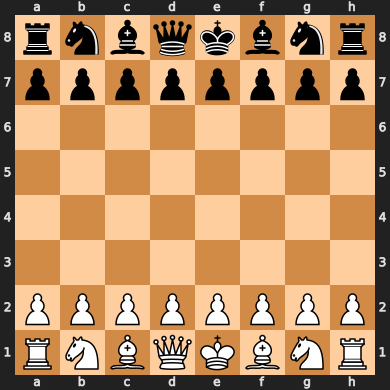

In [7]:
board = first_game.board()
board

In [37]:
for move in board.legal_moves:
    new_board = board.copy()
    new_board.push(move)
    print(move, transform(new_board))

g1h3 rnbqkb#r/pppppppp/#####n##/########/###P####/#######N/PPP#PPPP/RNBQKB#R 0 xX
g1f3 rnbqkb#r/pppppppp/#####n##/########/###P####/#####N##/PPP#PPPP/RNBQKB#R 0 xX
e1d2 rnbqkb#r/pppppppp/#####n##/########/###P####/########/PPPKPPPP/RNBQ#BNR 0 xU
d1d3 rnbqkb#r/pppppppp/#####n##/########/###P####/###Q####/PPP#PPPP/RNB#KBNR 0 xX
d1d2 rnbqkb#r/pppppppp/#####n##/########/###P####/########/PPPQPPPP/RNB#KBNR 0 xX
c1h6 rnbqkb#r/pppppppp/#####n#B/########/###P####/########/PPP#PPPP/RN#QKBNR 0 xX
c1g5 rnbqkb#r/pppppppp/#####n##/######B#/###P####/########/PPP#PPPP/RN#QKBNR 0 xX
c1f4 rnbqkb#r/pppppppp/#####n##/########/###P#B##/########/PPP#PPPP/RN#QKBNR 0 xX
c1e3 rnbqkb#r/pppppppp/#####n##/########/###P####/####B###/PPP#PPPP/RN#QKBNR 0 xX
c1d2 rnbqkb#r/pppppppp/#####n##/########/###P####/########/PPPBPPPP/RN#QKBNR 0 xX
b1c3 rnbqkb#r/pppppppp/#####n##/########/###P####/##N#####/PPP#PPPP/R#BQKBNR 0 xX
b1a3 rnbqkb#r/pppppppp/#####n##/########/###P####/N#######/PPP#PPPP/R#BQKBNR 0 xX
b1d2 rnbqkb#r/pp

In [36]:
board.has_castling_rights(0) 

True

In [9]:
moves = list(first_game.mainline_moves())

d2d4


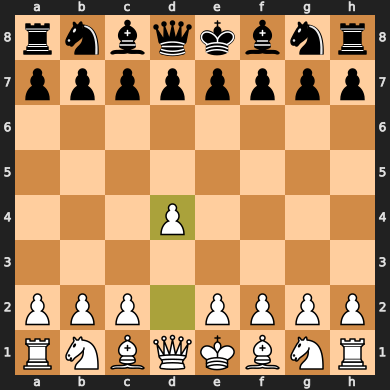

In [10]:
first_move = moves[0]
print(first_move)
board.push(first_move)
board

g8f6


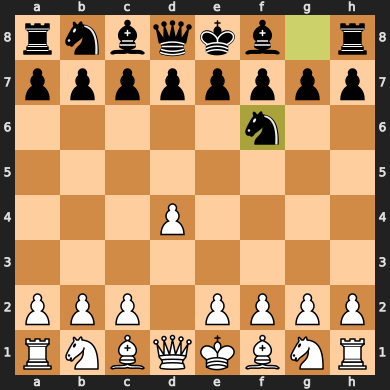

In [11]:
second_move = moves[1]
print(second_move)
board.push(second_move)
board

## Move encoding

In [12]:
# we could reduce the vocab size by only considering the queen and knight moves
# for each square in the board
moves_vocab = [a + b for a, b in itertools.product(chess.SQUARE_NAMES, chess.SQUARE_NAMES) if a != b]

# add promotion moves
for move in moves_vocab:
    if move.endswith(("1", "8")):
        moves_vocab.append(move + "q")
        moves_vocab.append(move + "r")
        moves_vocab.append(move + "b")
        moves_vocab.append(move + "n")

moves_stoi = {move: i for i, move in enumerate(moves_vocab)}
moves_itos = {i: move for i, move in enumerate(moves_vocab)}
print(len(moves_vocab))

8064


In [13]:
move = "e2e4"

moves_encode = lambda x: moves_stoi[x]
moves_decode = lambda x: moves_itos[x]

print(moves_encode(move))
print(moves_decode(moves_encode(move)))

783
e2e4


## Build dataset

In [14]:
def build_dataset(pgn_file, player=None):
    boards = []
    moves = []
    with open(pgn_file) as games:
        while True:
            game = pgn.read_game(games)
            if game is None:
                break
            board = game.board()
            player = chess.WHITE if game.headers["White"] == player else chess.BLACK
            fen = transform(board)
            for move in game.mainline_moves():
                if board.turn == player:
                    boards.append(board_encode(fen))
                    moves.append(moves_encode(move.uci()))
                board.push(move)
    return np.array(boards), np.array(moves)

In [15]:
# Our goal is to produce Magnus Carlsen like games, so we will only include his moves in our data
boards, moves = build_dataset("../data/master_games.pgn", player="Carlsen, Magnus")
print(boards.shape)
print(moves.shape)

(1108, 76)
(1108,)


In [19]:
import torch
boards = torch.from_numpy(boards).long()
moves = torch.from_numpy(moves).long()

In [20]:
boards[0], moves[0]

(tensor([21, 23, 22, 20, 19, 22, 23, 21,  1, 24, 24, 24, 24, 24, 24, 24, 24,  1,
         12, 12, 12, 12, 12, 12, 12, 12,  1, 12, 12, 12, 12, 12, 12, 12, 12,  1,
         12, 12, 12, 12, 12, 12, 12, 12,  1, 12, 12, 12, 12, 12, 12, 12, 12,  1,
         18, 18, 18, 18, 18, 18, 18, 18,  1, 15, 17, 16, 14, 13, 16, 17, 15,  0,
          3,  0, 10, 11]),
 tensor(719))

In [21]:
# train test split
n = int(0.8 * len(boards))
train_boards, train_moves = boards[:n], moves[:n]
val_boards, val_moves = boards[n:], moves[n:]

In [28]:
# one board is always encoded with 76 characters
torch.manual_seed(666)
batch_size = 4


def get_batch(split):
    boards = train_boards if split == "train" else val_boards
    moves = train_moves if split == "train" else val_moves
    i = torch.randint(0, len(boards), (batch_size,))
    x = boards[i]
    y = moves[i]
    return x, y

In [34]:
import math
import torch.nn as nn


class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        # max_len determines how far the position can have an effect on a token (window)
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        
        pos_encoding = torch.zeros(max_len, dim_model)
        position_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1)
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0) / dim_model))

        # PE(pos, 2i) = sin(pos / 10000^(2i / dim_model))
        pos_encoding[:, 0::2] = torch.sin(position_list * division_term)

        # PE(pos, 2i+1) = cos(pos / 10000^(2i / dim_model))
        pos_encoding[:, 1::2] = torch.cos(position_list * division_term)

        # add a batch dimension
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pos_encoding', pos_encoding)
    
    def forward(self, token_embedding):
        # residual connection + pos encoding + dropout
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])



In [ ]:
class ChessModel(nn.Module):
    """
    board_vocab: number of tokens in the board vocabulary
    moves_vocab: number of tokens in the moves vocabulary
    board_len: dimension of te board encoding
    dim_model: dimension of the model
    num_heads: number of heads in the multi-head attention
    num_encoder_layers: number of encoder layers
    num_decoder_layers: number of decoder layers
    dropout_p: dropout probability
    """
    def __init__(self,
                 board_len,
                 board_vocab,
                 dim_model,
                 num_heads,
                 num_encoder_layers,
                 num_decoder_layers,
                 dropout_p,
    ):
        super().__init__()
        self.dim_model = dim_model

        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=board_len
        )

        encode_layers = nn.TransformerEncoderLayer(
            d_model=dim_model, nhead=num_heads, dropout=dropout_p, batch_first=True
            )
        decode_layers = nn.TransformerDecoderLayer(
            d_model=dim_model, nhead=num_heads, dropout=dropout_p, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encode_layers, num_encoder_layers)
        self.transformer_decoder = nn.TransformerDecoder(decode_layers, num_decoder_layers)

        # emnedding layer transforms list of integer tokens into a list of vectors
        self.embedding = nn.Embedding(board_vocab, dim_model)

    def forward(self, board, tgt_board):
        src_board = self.encode(board)
        src_board = self.transformer_encoder(src_board)
        for move in board.legal_moves:
            new_board = board.copy()
            new_board.push(move)
            new_board = self.encode(new_board)
            new_board = self.transformer_decoder(new_board, src_board)

    def encode(self, board):
        board = transform(board)
        board = board_encode(board)
        board = self.embedding(board) * math.sqrt(self.dim_model)
        return self.positional_encoder(board)


Plan:
Input: board at time t
Output: for every possible move
            play move
            encode board as target
            use it as target in transformer
            linear unit to score target
            vote among all possible outputs
            output board at time t + 1
